# Advanced manual
This notebook shows some methods to make the customized target generator in more advaned ways. 

First, run the following lines.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from backtest_engine import BacktestEngine
from target_generator import TargetGenerator

# Available Ticker (use yahoo finance)
  
### Basic Index
yf_ticker_list = [  
    '^GSPC','^IXIC','^DJI','^RUT','^VIX','^TNX','^SP500TR',  
    'GC=F', 'CL=F']  
### Broad Market ETF
yf_ticker_list += [  
    'SPY', # SPDR S&P 500 ETF Trust # 1993-01-22  
    'EFA', # iShares MSCI EAFE ETF # 2001-08-14  
    'EEM', # iShares MSCI Emerging Markets ETF # 2003-04-07  
    'AGG', # iShares Core U.S. Aggregate Bond ETF # 2003-09-22  
    ]
### Fixed Income ETF
yf_ticker_list += [  
    'SHY', # iShares 1-3 Year Treasury Bond ETF # 2002-07-22  
    'IEF', # iShares 7-10 Year Treasury Bond ETF # 2002-07-22  
    'TLH', # iShares 10-20 Year Treasury Bond ETF # 2007-01-05  
    'TLT', # iShares 20+ Year Treasury Bond ETF # 2002-07-22  
    'AGG', # iShares Core U.S. Aggregate Bond ETF # 2003-09-22  
    'LQD', # iShares iBoxx Investment Grade Corporate Bond ETF # 2002-07-22  
    'HYG', # iShares iBoxx High Yield Corporate Bond ETF # 2007-04-04  
    'TIP', # iShares TIPS Bond ETF # 2003-12-04  
    'MBB', # iShares MBS ETF # 2007-03-13  
    'EMB', # iShares J.P. Morgan USD Emerging Markets Bond ETF # 2007-12-17  
]  
### Alternative Asset ETF  
yf_ticker_list += [  
    'VNQ', # Vanguard Real Estate Index Fund # 2004-09-23  
    'GLD', # SPDR Gold Shares # 2004-11-18  
    'IGF', # iShares Global Infrastructure ETF # 2007-12-10  
    'USO', # United States Oil Fund, LP # 2006-04-10  
    'UUP', # Invesco DB US Dollar Index Bullish Fund # 2007-07-20  
    ]  
yf_ticker_list += [  
    'XLC', # Communication Services Select Sector SPDR Fund # 2018-06-18  
    'XLY', # Consumer Discretionary Select Sector SPDR Fund # 1998-12-16  
    'XLP', # Consumer Staples Select Sector SPDR Fund # 1998-12-16  
    'XLE', # Energy Select Sector SPDR Fund # 1998-12-16  
    'XLF', # Financial Select Sector SPDR Fund # 1998-12-16  
    'XLV', # Health Care Select Sector SPDR Fund # 1998-12-16  
    'XLI', # Industrial Select Sector SPDR Fund # 1998-12-16  
    'XLB', # Materials Select Sector SPDR Fund # 1998-12-16  
    'XLK', # Technology Select Sector SPDR Fund # 1998-12-16  
    'XLU', # Utilities Select Sector SPDR Fund # 1998-12-16  
    ]  

# Available Index (use FRED)  
  
### Daily Market  
market_fred_list = [    
    'BAMLH0A0HYM2', # ICE BofA US High Yield Index Option-Adjusted Spread # 1996-12-31  
    'BAMLC0A4CBBB', # ICE BofA BBB US Corporate Index Option-Adjusted Spread # 1996-12-31  
    'BAMLH0A3HYC',  # ICE BofA CCC & Lower US High Yield Index Option-Adjusted Spread # 1996-12-31  
    'T10Y2Y', # 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity # 1976-06-01  
    'T10YIE', # 10-Year Breakeven Inflation Rate # 2003-01-02  
    'T5YIE',  # 5-Year Breakeven Inflation Rate # 2003-01-02   
    ]  
  
### Periodic Macro Index  
fred_list = [  
   'CSUSHPINSA', # S&P/Case-Shiller U.S. National Home Price Index # 1987-01-01  
   'UMCSENT' ,   # University of Michigan: Consumer Sentiment # 1952-11-01  
   'CPIAUCSL',   # Consumer Price Index for All Urban Consumers: All Items in U.S. City Average  # 1947-01-01  
   'PCE',  # Personal Consumption Expenditures  # 1959-01-01  
   'M2SL', # M2 #1959-01-01  
   'ICSA', # Initial Claims # 1967-01-07  
]  

In [14]:
# engine = BacktestEngine()
custom_universe = ['XLY', 'XLP', 'XLE' ,'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
engine = BacktestEngine(yfinance_list=custom_universe)

[__init__] is executed in 19.63 seconds


In [15]:
# You can add tickers if you need

# macro data can be added by fred_list arg
print("available macro data : " ,engine.cache['macro'].keys())

# index data can be added by yfinance_list arg
print("available index data : " ,engine.cache['index'].keys())

# index data can be added by market_fred_list arg
print("available market data : " ,engine.cache['market'].keys())

available macro data :  dict_keys(['M2', 'PCE', 'CPIAUCSL', 'ICSA'])
available index data :  dict_keys(['SPY', 'XLP', 'XLV', 'XLI', 'XLY', 'XLF', 'XLB', 'XLE', 'XLU', 'XLK'])
available market data :  dict_keys(['T5YIE', 'T10Y2Y', 'BAMLH0A0HYM2'])


### CPI-based momentum/volatility rotation strategy
The following class allocates the weight according to inflation sign (CPI YoY). If CPI_YoY > 0, the weights are allocated on momentum ETFs. If CPI_YoY < 0, the weights are allocated on low-volatility ETFs.

In [16]:
class MomentumWeightGenerator(TargetGenerator):
    def __init__(self, cache):
        super().__init__(cache)

    def compute_target(self, universe_list):
        """
        Inputs
            universe_list(list) : list of ETFs that weights should be computed
        Outputs
            target_weight(dict)
        """
        target_weight = {}

        momentum_zscore = self.compute_factor_zscore(universe_list=universe_list, ftype='momentum')
        invVol_zscore = self.compute_factor_zscore(universe_list=universe_list, ftype='invVol')      

        CPI = self.get_value(ticker='CPIAUCSL', table='macro', value='value', lag=0)
        CPI_12M = self.get_value(ticker='CPIAUCSL', table='macro', value='value', lag=12)
        CPI_chg_YoY = np.log(float(CPI)/float(CPI_12M))
        """
        get_value method
        Inputs
            ticker : name of ETF, index, or macro-data
            table : 'index' if ticker is ETF/index, or 'macro' if ticker is macro-data
            value : 'openadj', 'highadj', 'lowadj', 'closeadj' for 'index' table and 'value' for 'macro' table
            lag : number of lagged data points (lag=0 gives the point-in-time latest availabe data)
            float
        """

        if CPI_chg_YoY > 0 :
            for ticker in universe_list:
                if ticker in momentum_zscore.index and momentum_zscore[ticker] > 0:
                    target_weight[ticker] = momentum_zscore[ticker]
        else:
            for ticker in universe_list:
                if ticker in invVol_zscore.index and invVol_zscore[ticker] > 0:
                    target_weight[ticker] = invVol_zscore[ticker]

        target_weight = self.normalize(target_weight)

        return target_weight

    def compute_factor_zscore(self, universe_list, ftype):
        """
        compute_factor_zscore method
        Inputs
            universe_list(list)
            ftype(str)
        Outputs
            pd.Series
        """  
        ticker_to_factor = {}
        for ticker in universe_list:
            try:
                factor = self.compute_factor(ticker, ftype)
            except:
                factor = np.nan
            if np.isnan(factor):
                pass
            else:
                ticker_to_factor[ticker] = factor
        factor_series = pd.Series(ticker_to_factor).dropna().sort_values(ascending=False)
        factor_series = (factor_series-factor_series.mean())/factor_series.std()
        
        return factor_series  

    def compute_factor(self, ticker, ftype):
        """
        Inputs
            ticker(str) : name of ETF
            ftype(str) : name of factor
        Outputs
            float
        """
        try:
            if ftype == 'momentum':
                return self.momentum_factor(ticker=ticker)
            
            elif ftype == 'invVol':
                return self.inverse_vol_factor(ticker=ticker)
        except:
            return np.nan
        
            
    def momentum_factor(self, ticker):
        price = self.get_value(ticker=ticker, table='index', value='closeadj', lag=0) 
        price_12M = self.get_value(ticker=ticker, table='index', value='closeadj', lag=252) 
        """
        get_value method
        Inputs
            ticker : name of ETF, index, or macro-data
            table : 'index' if ticker is ETF/index, or 'macro' if ticker is macro-data
            value : 'openadj', 'highadj', 'lowadj', 'closeadj' for 'index' table / 'value' for 'macro' and 'market' table
            lag : number of lagged data points (lag=0 gives the point-in-time latest availabe data)
            float
        """
        momentum = np.log(price/price_12M)
        return momentum
    
    def inverse_vol_factor(self, ticker):
        price_series = self.get_value_series(ticker=ticker, table='index', value='closeadj', lag=252)
        """
        get_value_series method
        Inputs
            ticker : name of ETF, index, or macro-data
            table : 'index' if ticker is ETF/index, or 'macro' if ticker is macro-data
            value : open, high, low, close for 'index' table and value for 'macro' table
            lag : number of lagged data points
        Outputs
            pd.Series
        """
        vol = price_series.apply(np.log).diff().std()
        return 1/vol

In [17]:
mtg = MomentumWeightGenerator(engine.cache)
custom_universe = ['XLY', 'XLP', 'XLE' ,'XLF', 'XLV', 'XLI', 'XLB', 'XLK', 'XLU']
# engine.run_backtest(target_generator=mtg, sdate='2010-01-01', edate='2021-01-01', custom_universe = custom_universe)
engine.run_backtest(target_generator=mtg, sdate='2010-01-01', edate='2021-01-01')

Backtest period: 2010-01-04 00:00:00 -- 2020-12-31 00:00:00
=== date:2020-12-31 00:00:00 / total_asset:3.083 / time elapsed:3.7 ===
[run_backtest] is executed in 3.86 seconds


### Visualization
Now let us compare the performance of the strategy with S&P 500 index.

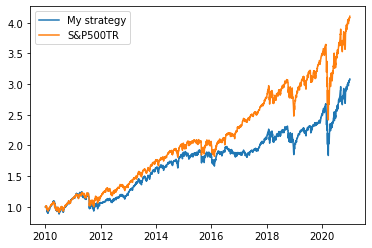

In [18]:
myasset = engine.asset_df.sum(axis=1)
benchmark = engine.cache['index']['SPY']['closeadj'].loc[myasset.index]
benchmark = benchmark/benchmark.iloc[0]

plt.plot(myasset)
plt.plot(benchmark)
plt.legend(['My strategy', 'S&P500TR'])

My strategy failed to beat the benchmark. Its time to make your own!

### View cache
You can view cache data as follows.

In [19]:
print(engine.cache['macro'].keys())
engine.cache['macro']['CPIAUCSL']
# datekey : date when the value is announced
# cdate : carlendar date
# is_inferred : whether the datekey is inferred from cdate or not 

dict_keys(['M2', 'PCE', 'CPIAUCSL', 'ICSA'])


,value,is_inferred,cdate,ticker
datekey,,,,
1947-02-16,21.48,True,1947-01-01,CPIAUCSL
1947-03-19,21.62,True,1947-02-01,CPIAUCSL
1947-04-16,22.0,True,1947-03-01,CPIAUCSL
1947-05-17,22.0,True,1947-04-01,CPIAUCSL
1947-06-16,21.95,True,1947-05-01,CPIAUCSL
...,...,...,...,...
2022-02-10,281.933,False,2022-01-01,CPIAUCSL
2022-03-10,284.182,False,2022-02-01,CPIAUCSL
2022-04-12,287.708,False,2022-03-01,CPIAUCSL


In [20]:
print(engine.cache['market'].keys())
engine.cache['market']['BAMLH0A0HYM2']
# datekey : date when the value is announced
# cdate : carlendar date
# is_inferred : whether the datekey is inferred from cdate or not 

dict_keys(['T5YIE', 'T10Y2Y', 'BAMLH0A0HYM2'])


,value,ticker
date,,
2000-01-03,4.68,BAMLH0A0HYM2
2000-01-04,4.81,BAMLH0A0HYM2
2000-01-05,4.77,BAMLH0A0HYM2
2000-01-06,4.82,BAMLH0A0HYM2
2000-01-07,4.86,BAMLH0A0HYM2
...,...,...
2019-12-26,3.53,BAMLH0A0HYM2
2019-12-27,3.56,BAMLH0A0HYM2
2019-12-30,3.60,BAMLH0A0HYM2


In [21]:
print(engine.cache['index'].keys())
engine.cache['index']['SPY']

dict_keys(['SPY', 'XLP', 'XLV', 'XLI', 'XLY', 'XLF', 'XLB', 'XLE', 'XLU', 'XLK'])


,openadj,highadj,lowadj,closeadj,volume,dividends,stock splits,ticker
date,,,,,,,,
1993-01-29,25.456182,25.456182,25.329534,25.438089,1003200,0.0,0.0,SPY
1993-02-01,25.456188,25.619020,25.456188,25.619020,480500,0.0,0.0,SPY
1993-02-02,25.600930,25.691392,25.546652,25.673300,201300,0.0,0.0,SPY
1993-02-03,25.709478,25.962774,25.691386,25.944681,529400,0.0,0.0,SPY
1993-02-04,26.035149,26.107519,25.745669,26.053242,531500,0.0,0.0,SPY
...,...,...,...,...,...,...,...,...
2022-06-27,391.049988,391.359985,387.440002,388.589996,66009600,0.0,0.0,SPY
2022-06-28,390.230011,393.160004,380.529999,380.649994,86548900,0.0,0.0,SPY
2022-06-29,381.230011,382.269989,378.420013,380.339996,65676000,0.0,0.0,SPY


In [22]:
engine.asset_df

,cash,XLY,XLK,XLB,SPY,XLI,XLF,XLP,XLU,XLE,XLV
2010-01-04,0.0,0.237484,0.405333,0.357183,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
2010-01-05,0.0,0.238355,0.404810,0.358338,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
2010-01-06,0.0,0.238672,0.400281,0.364427,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
2010-01-07,0.0,0.240651,0.398713,0.361593,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
2010-01-08,0.0,0.240572,0.401326,0.366632,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.0,0.786940,1.223362,0.460807,0.331924,0.016631,0.0,0.071741,0.0,0.0,0.154509
2020-12-28,0.0,0.795912,1.237202,0.459004,0.334775,0.016652,0.0,0.072311,0.0,0.0,0.154897
2020-12-29,0.0,0.796161,1.231324,0.457910,0.334137,0.016552,0.0,0.072096,0.0,0.0,0.155631
2020-12-30,0.0,0.800946,1.230661,0.464219,0.334614,0.016658,0.0,0.072021,0.0,0.0,0.155604


In [23]:
engine.asset_df.columns

Index(['cash', 'XLY', 'XLK', 'XLB', 'SPY', 'XLI', 'XLF', 'XLP', 'XLU', 'XLE',
       'XLV'],
      dtype='object')